In [79]:
import time
print(time.time())
import pandas as pd
import numpy as np
import os
import itertools

from sklearn.model_selection import GridSearchCV

from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import math
from scipy.stats import iqr
from numpy import linalg
import matplotlib.pyplot as plt
print(time.time())
from scipy import stats

#feature selection
from sklearn.ensemble import ExtraTreesClassifier

#label encoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

#Feature Normalisation
from sklearn.preprocessing import StandardScaler

#Feature Extraction
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD



#supervised
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

#metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve,roc_curve
from sklearn.metrics import auc
import _pickle as pickle

1521179667.6731534
1521179667.678168


In [80]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

In [81]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep]

In [82]:
train_data = pd.read_csv("5sec_smooth_cropped_38_best_feat.csv",index_col = 0)

print(train_data.shape)

(6543, 40)


In [83]:
train_data.head()

,mean_acc_x,mean_acc_y,mean_acc_z,std_acc_z,mad_acc_x,min_acc_x,min_acc_y,max_acc_x,max_acc_y,max_acc_z,...,mad_mfacc_jerk,max_mfacc_jerk,mean_macc,std_macc,mad_macc,max_macc,em_macc,iqr_macc,sma_macc,label
0,-1.339722,-3.476718,8.732722,1.265379,0.153846,-3.617904,-12.087901,1.604397,1.173643,14.510912,...,3212.522649,27940.523324,9.688410,1.017775,0.079896,17.056087,94.901163,0.165016,9.688410,sitting
1,-1.892818,-3.044553,8.950002,0.077371,0.062704,-2.179921,-3.478221,-1.655746,-2.611153,9.139097,...,3283.264733,29429.865300,9.643841,0.054694,0.034248,9.804784,93.006651,0.068135,9.643841,sitting
2,-1.823438,-3.192150,8.924490,0.060596,0.032677,-2.121877,-3.454627,-1.672819,-2.951709,9.106545,...,3233.340381,33595.945594,9.652677,0.046713,0.024758,9.804784,93.176360,0.049229,9.652677,sitting
3,-1.873861,-2.878490,8.338558,3.278953,0.046989,-2.858703,-3.377095,-1.672819,-1.695607,9.198854,...,3306.549242,35149.614275,9.593202,0.443135,0.031136,9.763954,92.225891,0.063242,9.593202,sitting
4,-1.856301,-2.573843,8.803868,2.199987,0.055864,-2.857922,-3.104704,-1.600225,-1.695607,9.284430,...,3326.350518,35149.614275,9.611132,0.308495,0.034550,9.788829,92.469032,0.069095,9.611132,sitting


In [84]:
train_data = clean_dataset(train_data)

In [85]:
train_data.shape

(6543, 40)

In [86]:
train_data_shuffled = train_data.iloc[np.random.permutation(len(train_data))]

In [87]:
train_features_s = train_data_shuffled.copy()
print(train_features_s.shape)
train_labels_s = train_features_s["label"]
train_features_s = train_features_s.drop(["label"], axis = 1)
print(train_features_s.shape)

(6543, 40)
(6543, 39)


In [88]:
le_s = LabelEncoder()
print(train_labels_s[0:5])
train_labels_s = le_s.fit_transform(train_labels_s)
print(train_labels_s[0:5])

3303     sitting
614     standing
5135     walking
1082     sitting
950      walking
Name: label, dtype: object
[1 2 3 1 3]


In [89]:
std_scale_s = StandardScaler()
print(train_features_s.shape)
train_features_s = std_scale_s.fit_transform(train_features_s)
print(train_features_s.shape)

(6543, 39)
(6543, 39)


In [90]:
models = ["Decision Tree", "Random Forest", "Svm", "MLP", "Xgboost", "LogisticReg", "GaussianNB", "KNN"]
for model in models:
    print(model)
    if model == "Decision Tree":
        clf = DecisionTreeClassifier()
    if model == "Random Forest":
        clf = RandomForestClassifier()
    if model == "Svm":
        clf = svm.SVC()
    if model == "MLP":
        clf = MLPClassifier()
    if model == "Xgboost":
        clf = XGBClassifier()
    if model == "LogisticReg":
        clf = LogisticRegression()
    if model == "GaussianNB":
        clf = GaussianNB()
    if model == "KNN":
        clf = KNeighborsClassifier()

            
    mean_cv_score = np.mean(cross_val_score(clf,train_features_s,train_labels_s,cv = 10))
    print(mean_cv_score)

Decision Tree
0.9503323820377435
Random Forest
0.9695808039330581
Svm
0.9362738881017361
MLP
0.9706523089860948
Xgboost


d:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

0.9639312215379439
LogisticReg
0.9015758900722723
GaussianNB
0.7954999280605527
KNN
0.9642325943365109


# Test set formation

In [94]:
test_data = pd.read_csv("5sec_smooth_cropped_38_best_feat_test_vid.csv",index_col = 0)

print(test_data.shape)

(492, 40)


In [95]:
test_features = test_data.copy()
print(test_features.shape)
test_labels = test_features["label"]
test_features = test_features.drop(["label"], axis = 1)
print(test_features.shape)

(492, 40)
(492, 39)


In [96]:
print(test_labels[0:5])
test_labels = le_s.transform(test_labels)
print(test_labels[0:5])

0    sitting
1    sitting
2    sitting
3    sitting
4    sitting
Name: label, dtype: object
[1 1 1 1 1]


In [97]:
print(test_features.shape)
test_features = std_scale_s.transform(test_features)
print(test_features.shape)

(492, 39)
(492, 39)


In [101]:
for model in models:
    print(model)
    if model == "Decision Tree":
        clf = DecisionTreeClassifier()
    if model == "Random Forest":
        clf = RandomForestClassifier()
    if model == "Svm":
        clf = svm.SVC()
    if model == "MLP":
        clf = MLPClassifier()
    if model == "Xgboost":
        clf = XGBClassifier()
    if model == "LogisticReg":
        clf = LogisticRegression()
    if model == "GaussianNB":
        clf = GaussianNB()
    if model == "KNN":
        clf = KNeighborsClassifier()

    clf.fit(train_features_s,train_labels_s)
    preds = clf.predict(test_features)
    mean_cv_score = accuracy_score(test_labels,preds)
    print(mean_cv_score)

Decision Tree
0.4491869918699187
Random Forest
0.483739837398374
Svm
0.5386178861788617
MLP
0.42073170731707316
Xgboost


d:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.42276422764227645
LogisticReg
0.4451219512195122
GaussianNB
0.4532520325203252
KNN
0.4715447154471545


# Grid Search 

In [16]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = accuracy_score(test_labels,predictions)
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [99]:
for model in ["DTree","KNN"]:
    print("Doing Grid Search for " + model)
    if model == "DTree":
        clf = DecisionTreeClassifier(random_state = 0)
        clf.fit(train_features_s,train_labels_s)
        preds = clf.predict(test_features)
        print(accuracy_score(test_labels,preds))
        best_accuracy = accuracy_score(test_labels,preds)
        
        for max_features in range(1,39):
            clf = DecisionTreeClassifier(max_features = max_features, random_state = 0)
            clf.fit(train_features_s,train_labels_s)
            preds = clf.predict(test_features)
            acc = accuracy_score(test_labels,preds)
            if acc > best_accuracy:
                print(str(max_features) + " " +  str(acc))
                best_accuracy = acc
    if model == "KNN":
        clf = KNeighborsClassifier()
        clf.fit(train_features_s,train_labels_s)
        preds = clf.predict(test_features)
        print(accuracy_score(test_labels,preds))
        best_accuracy = accuracy_score(test_labels,preds)
        
        for n_neighbors in range(1,500):
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(train_features_s,train_labels_s)
            preds = clf.predict(test_features)
            acc = accuracy_score(test_labels,preds)
            if acc > best_accuracy:
                print(str(n_neighbors) + " " +  str(acc))
                best_accuracy = acc
    
        
        
        
        
        

Doing Grid Search for DTree
0.4186991869918699
1 0.42886178861788615
2 0.5447154471544715
Doing Grid Search for KNN
0.4715447154471545
9 0.47764227642276424
11 0.483739837398374
14 0.5060975609756098
15 0.5264227642276422
16 0.5304878048780488
17 0.5447154471544715
25 0.5467479674796748
29 0.5508130081300813
31 0.5528455284552846
33 0.5589430894308943
36 0.5630081300813008
101 0.5650406504065041
105 0.5670731707317073
109 0.5691056910569106
133 0.5711382113821138
141 0.573170731707317
142 0.5772357723577236
144 0.5813008130081301
173 0.5833333333333334
189 0.5853658536585366
236 0.5873983739837398
238 0.5894308943089431
253 0.5914634146341463
254 0.5955284552845529
295 0.5975609756097561
301 0.5995934959349594
327 0.6016260162601627


In [102]:
clf = KNeighborsClassifier(n_neighbors = 327)
clf.fit(train_features_s,train_labels_s)
preds = clf.predict(test_features)
print(accuracy_score(test_labels,preds))

0.6016260162601627


In [104]:
pickle.dump(clf, open("best_model_39feat.pkl","wb"))


In [105]:
pickle.dump(le_s, open("label_encoder_39feat.pkl","wb"))
pickle.dump(std_scale_s, open("standard_scaler_39feat.pkl","wb"))

# Repeating for 10 sec window data shuffled and cropped

In [17]:
smooth_train_data = pd.read_csv("10sec_smooth_cropped_288feat.csv",index_col = 0)

print(smooth_train_data.shape)

(3934, 289)


In [18]:
smooth_train_data_shuffled = smooth_train_data.iloc[np.random.permutation(len(smooth_train_data))]

In [19]:
smooth_train_data_shuffled = clean_dataset(smooth_train_data_shuffled)
smooth_train_features_s = smooth_train_data_shuffled.copy()
print(smooth_train_features_s.shape)
smooth_train_labels_s = smooth_train_features_s["label"]
smooth_train_features_s = smooth_train_features_s.drop(["label"], axis = 1)
print(smooth_train_features_s.shape)

(3934, 289)
(3934, 288)


In [20]:
le_s = LabelEncoder()
print(smooth_train_labels_s[0:5])
smooth_train_labels_s = le_s.fit_transform(smooth_train_labels_s)
print(smooth_train_labels_s[0:5])

1345       standing
115     laying_down
730     laying_down
3837        walking
3752        sitting
Name: label, dtype: object
[2 0 0 3 1]


In [21]:
std_scale_s = StandardScaler()
print(smooth_train_features_s.shape)
smooth_train_features_s = std_scale_s.fit_transform(smooth_train_features_s)
print(smooth_train_features_s.shape)

(3934, 288)
(3934, 288)


### test set formation

In [23]:
smooth_test_data = pd.read_csv("vidushi_288_10sc.csv",index_col = 0)

print(smooth_test_data.shape)

(241, 289)


In [24]:
smooth_test_features = smooth_test_data.copy()
print(smooth_test_features.shape)
smooth_test_labels = smooth_test_features["label"]
smooth_test_features = smooth_test_features.drop(["label"], axis = 1)
print(smooth_test_features.shape)

(241, 289)
(241, 288)


In [25]:
print(smooth_test_labels[0:5])
smooth_test_labels = le_s.transform(smooth_test_labels)
print(smooth_test_labels[0:5])

0    sitting
1    sitting
2    sitting
3    sitting
4    sitting
Name: label, dtype: object
[1 1 1 1 1]


In [26]:
print(smooth_test_features.shape)
smooth_test_features = std_scale_s.transform(smooth_test_features)
print(smooth_test_features.shape)

(241, 288)
(241, 288)


In [27]:
models = ["Decision Tree", "Random Forest", "Svm", "MLP", "Xgboost", "LogisticReg", "GaussianNB", "KNN"]
for model in models:
    print(model)
    if model == "Decision Tree":
        clf = DecisionTreeClassifier()
        clf.fit(smooth_train_features_s,smooth_train_labels_s)
    if model == "Random Forest":
        clf = RandomForestClassifier()
        clf.fit(smooth_train_features_s,smooth_train_labels_s)
    if model == "Svm":
        clf = svm.SVC()
        clf.fit(smooth_train_features_s,smooth_train_labels_s)
    if model == "MLP":
        clf = MLPClassifier()
        clf.fit(smooth_train_features_s,smooth_train_labels_s)
    if model == "Xgboost":
        clf = XGBClassifier()
        clf.fit(smooth_train_features_s,smooth_train_labels_s)
    if model == "LogisticReg":
        clf = LogisticRegression()
        clf.fit(smooth_train_features_s,smooth_train_labels_s)
    if model == "GaussianNB":
        clf = GaussianNB()
        clf.fit(smooth_train_features_s,smooth_train_labels_s)
    if model == "KNN":
        clf = KNeighborsClassifier()
        clf.fit(smooth_train_features_s,smooth_train_labels_s)

    preds = clf.predict(smooth_test_features)
    
    print(accuracy_score(smooth_test_labels,preds))

Decision Tree
0.4854771784232365
Random Forest
0.4107883817427386
Svm
0.4315352697095436
MLP
0.4730290456431535
Xgboost


d:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.46473029045643155
LogisticReg
0.5560165975103735
GaussianNB
0.3941908713692946
KNN
0.5809128630705395


In [58]:
for model in ["DTree","KNN"]:
    print("Doing Grid Search for " + model)
    if model == "DTree":
        continue
        clf = DecisionTreeClassifier(random_state = 0)
        clf.fit(smooth_train_features_s,smooth_train_labels_s)
        preds = clf.predict(smooth_test_features)
        print(accuracy_score(smooth_test_labels,preds))
        best_accuracy = accuracy_score(smooth_test_labels,preds)
        
        for max_features in range(1,288):
            clf = DecisionTreeClassifier(max_features = max_features, random_state = 0)
            clf.fit(smooth_train_features_s,smooth_train_labels_s)
            preds = clf.predict(smooth_test_features)
            acc = accuracy_score(smooth_test_labels,preds)
            if acc > best_accuracy:
                print(str(max_features) + " " +  str(acc))
                best_accuracy = acc
    if model == "KNN":
        #continue
        clf = KNeighborsClassifier()
        clf.fit(smooth_train_features_s,smooth_train_labels_s)
        preds = clf.predict(smooth_test_features)
        print(accuracy_score(smooth_test_labels,preds))
        best_accuracy = accuracy_score(smooth_test_labels,preds)
        
        for n_neighbors in range(1,1000):
            clf = KNeighborsClassifier(n_neighbors = n_neighbors)
            clf.fit(smooth_train_features_s,smooth_train_labels_s)
            preds = clf.predict(smooth_test_features)
            acc = accuracy_score(smooth_test_labels,preds)
            if acc > best_accuracy:
                print(str(n_neighbors) + " " +  str(acc))
                best_accuracy = acc
            
        

Doing Grid Search for DTree
Doing Grid Search for KNN
0.5809128630705395
6 0.5933609958506224
8 0.6016597510373444
9 0.6224066390041494
25 0.6265560165975104
26 0.6307053941908713
34 0.6348547717842323
37 0.6390041493775933
39 0.6431535269709544
45 0.6473029045643154


# Estimating Metrics

d:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[32  4 17  1]
 [ 8 32 36  1]
 [ 0  2 47  0]
 [ 1  1 25 34]]


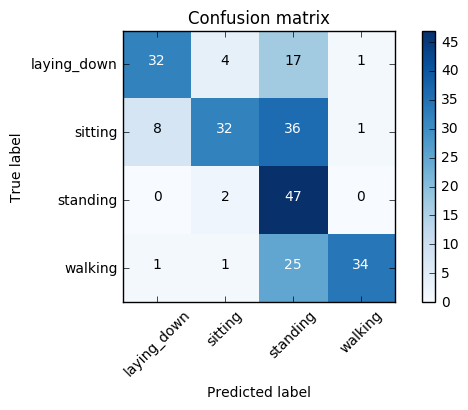

0.6016597510373444


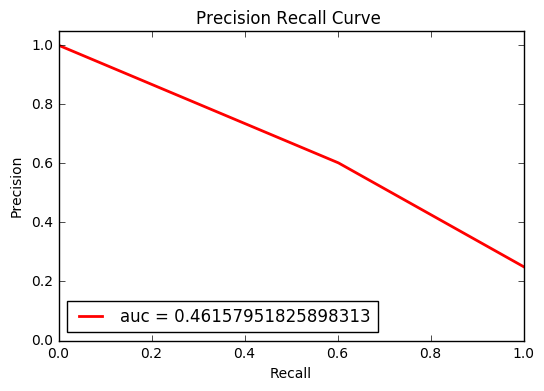

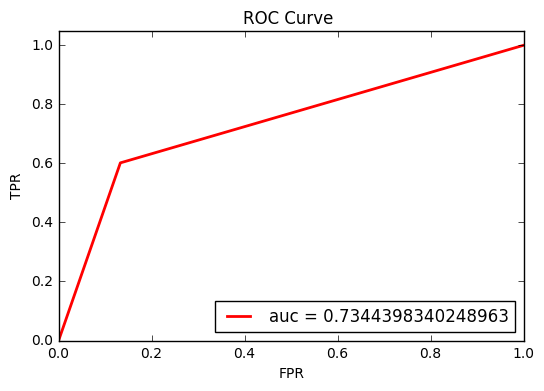

[0.7804878  0.82051282 0.376      0.94444444]


In [72]:
clf_DT = DecisionTreeClassifier(max_features = 31, random_state = 0)
clf_DT.fit(smooth_train_features_s,smooth_train_labels_s)
preds = clf_DT.predict(smooth_test_features)
#pred_labels = le_s.inverse_transform(preds)
#print(pred_labels[0:5])
plot_confusion_matrix(confusion_matrix(le_s.inverse_transform(smooth_test_labels),le_s.inverse_transform(preds)), classes = le_s.classes_)
print(accuracy_score(smooth_test_labels,preds))
score_dt = clf_DT.predict_proba(smooth_test_features)
p_dt = dict()
r_dt = dict()
pr_auc_dt = dict()
fpr_dt = dict()
tpr_dt = dict()
roc_auc_dt = dict()
smooth_test_labels_bin = label_binarize(smooth_test_labels, classes = [0,1,2,3])
p_dt["micro"],r_dt["micro"],_ = precision_recall_curve(smooth_test_labels_bin.ravel(),score_dt.ravel())
pr_auc_dt["micro"] = average_precision_score(smooth_test_labels_bin, score_dt,
                                                     average="micro")
fpr_dt["micro"],tpr_dt["micro"], _ = roc_curve(smooth_test_labels_bin.ravel(),score_dt.ravel())
roc_auc_dt["micro"] = auc(fpr_dt["micro"], tpr_dt["micro"])
plt.plot(r_dt["micro"], p_dt["micro"], color='red', lw=2,
            label='auc = {0}'.format(pr_auc_dt["micro"]))
plt.legend(loc="lower left")
plt.title('Precision Recall Curve ')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()
plt.plot(fpr_dt["micro"], tpr_dt["micro"], color='red',
         lw=2, label='auc = {0}'.format(roc_auc_dt["micro"]))
plt.legend(loc="lower right")
plt.title('ROC Curve ')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()
print(precision_score(smooth_test_labels, preds, average=None))

d:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
d:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Confusion matrix, without normalization
[[11 38  5  0]
 [ 4 56 17  0]
 [ 4  4 38  3]
 [ 2  1  7 51]]


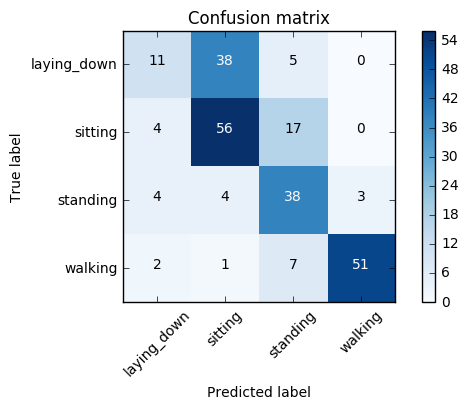

0.6473029045643154


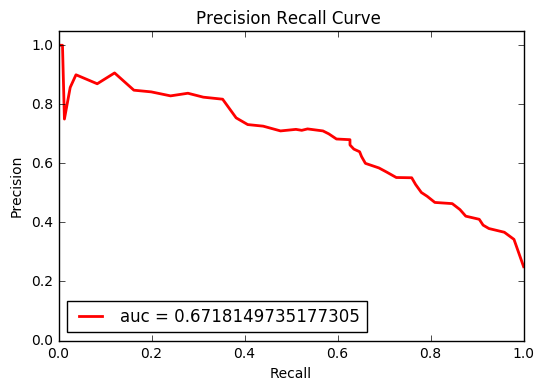

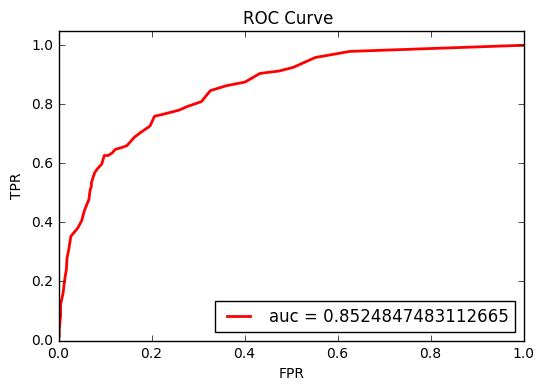

[0.52380952 0.56565657 0.56716418 0.94444444]


In [73]:
clf_knn = KNeighborsClassifier(n_neighbors = 45)
clf_knn.fit(smooth_train_features_s,smooth_train_labels_s)
preds = clf_knn.predict(smooth_test_features)
#pred_labels = le_s.inverse_transform(preds)
#print(pred_labels[0:5])
plot_confusion_matrix(confusion_matrix(le_s.inverse_transform(smooth_test_labels),le_s.inverse_transform(preds)), classes = le_s.classes_)
print(accuracy_score(smooth_test_labels,preds))
score_knn = clf_knn.predict_proba(smooth_test_features)
p_knn = dict()
r_knn = dict()
pr_auc_knn = dict()
fpr_knn = dict()
tpr_knn = dict()
roc_auc_knn = dict()
p_knn["micro"],r_knn["micro"],_ = precision_recall_curve(smooth_test_labels_bin.ravel(),score_knn.ravel())
pr_auc_knn["micro"] = average_precision_score(smooth_test_labels_bin, score_knn,
                                                     average="micro")
fpr_knn["micro"],tpr_knn["micro"], _ = roc_curve(smooth_test_labels_bin.ravel(),score_knn.ravel())
roc_auc_knn["micro"] = auc(fpr_knn["micro"], tpr_knn["micro"])
plt.plot(r_knn["micro"], p_knn["micro"], color='red', lw=2,
            label='auc = {0}'.format(pr_auc_knn["micro"]))
plt.legend(loc="lower left")
plt.title('Precision Recall Curve ')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()
plt.plot(fpr_knn["micro"], tpr_knn["micro"], color='red',
         lw=2, label='auc = {0}'.format(roc_auc_knn["micro"]))
plt.legend(loc="lower right")
plt.title('ROC Curve ')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

print(precision_score(smooth_test_labels, preds, average=None))


In [74]:
le_s.inverse_transform([0,1,2,3])

d:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['laying_down', 'sitting', 'standing', 'walking'], dtype=object)